# Basic Usage of DataMapPlot

This notebook will walk you through the basic usage patterns of DataMapPlot, from the format of the data you'll need to get started, to tweaking and saving a plot for use in a presentation, paper, or poster. To get started we'll need to import DataMapPlot. Also, for the purposes of this documentation, I need to keep the image sizes smaller to fit in readthedocs; because of that I will set the global DPI for matplotlib (which DataMapPlot uses for plotting), but you should probably remove those lines if you are running this notebook yourself.

In [1]:
# Ensure we don't generate large images for inline docs
# You probably want to remove this if running the notebook yourself
import matplotlib
matplotlib.rcParams["figure.dpi"] = 72

import datamapplot

Next we will need some data to plot. DataMapPlot has some example datasets, and we can simply pull those directly from github. For this example we'll use data about Wikipedia. The original data that this was derived from is the Wikipedia embeddings generated by Cohere using their ``embed`` system to generate paragraph embeddings. You can read more about that [on Cohere's blog-post about the dataset](https://txt.cohere.com/embedding-archives-wikipedia/). This particular dataset was derived from the embeddings of the ["Simple English" Wikipedia](https://simple.wikipedia.org/wiki/Main_Page), which contains 486 thousand paragraphs taken from around 200 thousand articles. A "Data Map" was created from this data using [UMAP for dimension reduction](https://github.com/lmcinnes/umap), and it was then clustered using [HDBSCAN](https://github.com/TutteInstitute/fast_hdbscan) to pick out topics. Each of these topics was then given a name (through a combination of LLMs and head tweaking) to create the labelled data map we'll be using.

So, without further ado, let's grab the data from github and load the numpy arrays:

In [2]:
import numpy as np
import requests
import io

data_map_file = requests.get("https://github.com/TutteInstitute/datamapplot/raw/main/examples/Wikipedia-data_map.npy")
wikipedia_data_map = np.load(io.BytesIO(data_map_file.content))
label_file = requests.get("https://github.com/TutteInstitute/datamapplot/raw/main/examples/Wikipedia-cluster_labels.npy")
wikipedia_labels = np.load(io.BytesIO(label_file.content), allow_pickle=True)

What does the data actually look like? The data map provides a two dimensional location for each paragraph, and is thus a 2d numpy array of float values:

In [3]:
wikipedia_data_map

array([[ 1.7236053,  3.706319 ],
       [ 1.7875007,  3.7248063],
       [ 1.7760702,  3.6861744],
       ...,
       [ 7.58305  , -4.234798 ],
       [ 7.7917733, -3.90715  ],
       [ 8.133467 , -3.991396 ]], dtype=float32)

In total we have almost 486 thousand rows, one for each paragraph in the original dataset.

In [4]:
wikipedia_data_map.shape

(485859, 2)

The topic label data is an array of text entries, with paragraphs that didn't fall into a specific topic (at the given clustering granularity) given the label ``'Unlabelled'``. Note that we have a label entry for each and every paragraph from the original dataset.

In [5]:
wikipedia_labels

array(['Unlabelled', 'Unlabelled', 'Unlabelled', ..., 'Television Series',
       'Unlabelled', 'Television Series'], dtype=object)

Thus we have almost 486 thousand labels, one for each row in the data map:

In [6]:
wikipedia_labels.shape

(485859,)

In the simplest usage we can simply hand this data to DataMapPlot and let it work out what to do. The goal of DataMapPlot is to automate as much of the work as possible, making it as easy as possible to get a good looking plot out. That means that DataMapPlot does all the heavy lifting of picking out topic centers, creating colour palettes, formatting the labels, finding a suitable font size and arranging the labels to avoid both overlapping labels and crossing label indicator lines, and plotting. All of that is handled with the base function ``create_plot``. For the most part, whever you are using DataMapPlot, the ``create_plot`` function is all you'll need, since it provides a great deal of options to tune and tweak results, some of which we'll look at in the further tutorial notebooks. For now we'll use it in the most straightforward way, and simply hand it the data map and the topic labels.

(<Figure size 864x864 with 1 Axes>, <Axes: >)

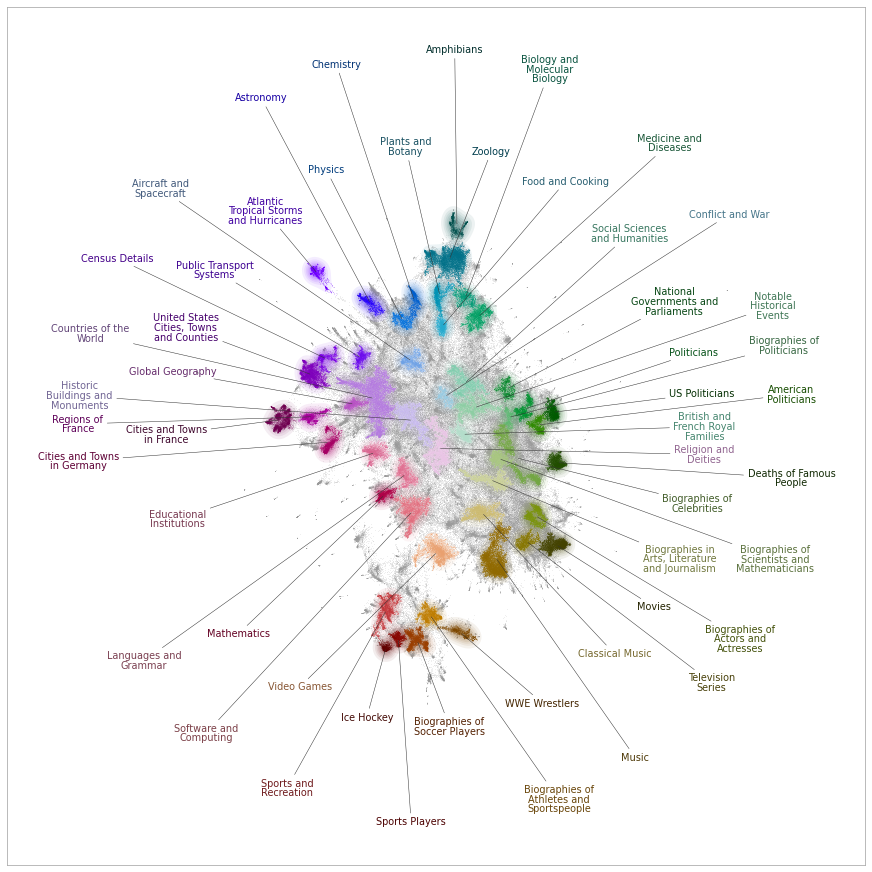

In [7]:
datamapplot.create_plot(wikipedia_data_map, wikipedia_labels)

As you can see, just handing DataMapPlot the data map and labels is enough to generate an attractive plot with all the clusters labelled. The default colour palette is designed such that nearby topics should have similar colours, but with enough variation to distinguish the topics. The labels are laid out in rings around the data map, which indicator arrows pointing to the cluster in the data map that the label refers to. By default the text labels are also coloured to match thematically with the colour of the cluster they are attached to, aiding in picking out which cluster the label refers to (see, for example, the "Religion and Deities" cluster above). DataMapPlot also attempts to make good choices about representing the data map itself; in particular for data maps with many points it defaults to using [datashader](https://datashader.org/) for rendering the data map, avoiding many [issues associated with overplotting and other associated plotting pitfalls](https://datashader.org/user_guide/Plotting_Pitfalls.html). Again, by default, DataMapPlot also adds a Kernel Density Estimate (KDE) based "glow" around clusters which can help highlight extremely small dense clusters; this can be turned off easily if required. All of this can be tweaked and adjusted, but the goal of DataMapPlot is to try to make good choices for you, and avoid hours of carefully tweaking the plot yourself by hand to get things "just right".

One thing to note here is that there are *a lot* of topics to be labelled. In fact there are fifty different text labels that have to placed in the plot. Nonetheless DataMapPlot has managed to find a reasonable layout that avoids overlapping text or crossing indicator lines. In practice DataMapPlot can handling up to 64 labels reasonably well; beyond that it will continue to function, and do it's best (now with three or more rings of labels), but label layout will be challenging and no promises can be made about the quality of the aesthetics in the result.

In fact even with fifty labels we have a few places where things are getting tightly packed. Let's prune things down a little by removing labels for some of the smallest clusters. To do that let's first look at the sizes of the various clusters: 

In [8]:
import pandas as pd

label_sizes = pd.Series(wikipedia_labels).value_counts()
label_sizes.reset_index()

,index,count
0,Unlabelled,239368
1,Countries of the World,16751
2,Music,15219
3,Zoology,14028
4,Religion and Deities,8438
5,Biographies of Celebrities,8311
6,Movies,8305
7,"United States Cities, Towns and Counties",8096
8,Cities and Towns in France,7497
9,Biographies of Actors and Actresses,6909


It seems not unreasonable to prune off clusters with fewer than 2500 paragraphs in them; that should unclustter things a little. While we are at it let's change the ``"Unlabelled"`` label given to paragraphs that didn't have a specific topic to something else -- in this case ``"No Topic"``.

In [9]:
simplified_labels = wikipedia_labels.copy()
simplified_labels[simplified_labels == "Unlabelled"] = "No Topic"
simplified_labels[np.in1d(simplified_labels, label_sizes[label_sizes < 2500].index)] = "No Topic"

By default DataMapPlot assumes that unclustered points are given the label ``"Unlabelled"``, but that isn't required. We can specify a name for the unclustered point label using the ``noise_label`` keyword argument to ``create_plot``. Let's see how our simplified label set looks:

(<Figure size 864x864 with 1 Axes>, <Axes: >)

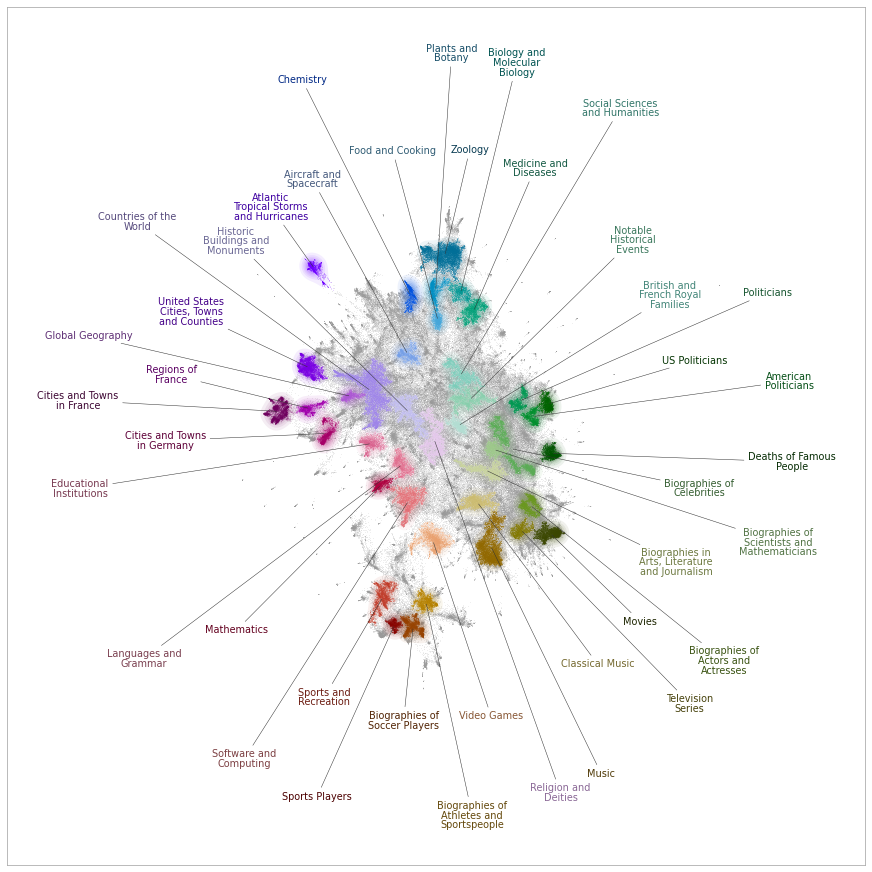

In [10]:
datamapplot.create_plot(wikipedia_data_map, simplified_labels, noise_label="No Topic")

Great! That did a good job of uncluttering things. This is looking like a plot we could keep. At this point it is time to add any final tweaks (here's we'll set a label font size, use medoids instead of centroids for where the indicator line points, and wrap the text labels more tightly), provide a title (and optionally a sub-title) and store the result figure and axis in some variables so we can save the generated plot.

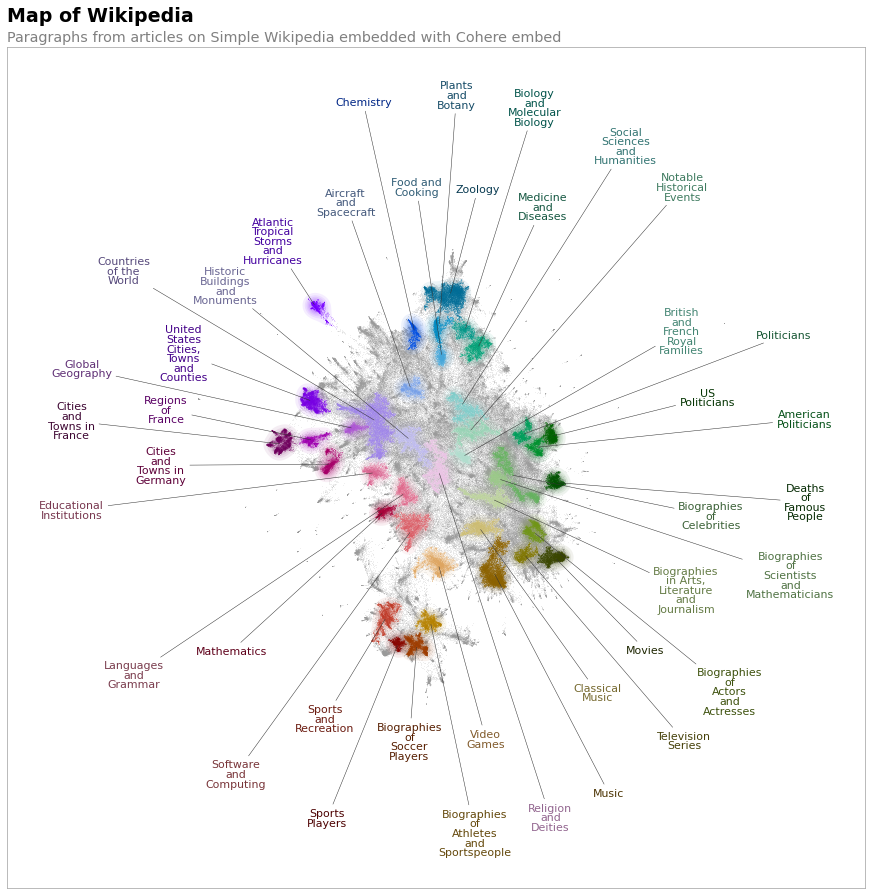

In [11]:
fig, ax = datamapplot.create_plot(
    wikipedia_data_map, 
    simplified_labels,
    noise_label="No Topic",
    title="Map of Wikipedia",
    sub_title="Paragraphs from articles on Simple Wikipedia embedded with Cohere embed",
    label_font_size=11,
    label_wrap_width=8,
    use_medoids=True,
)

That looks like what we want; now we need to save the plot. Fortunately the plot itself is simply a [matplotlib Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) instance. Thus we can leverage matplotlib's powerful tools for saving plots. To do this we call the ``savefig`` method and provide a filename to save to. Matplotlib is smart and will interpret the file extension in the filename to determine the format of the saved file. Here we'll simply save to a PNG, but you can equally well generate a JPG, PDF, or SVG file if you wish. The supported filetypes will vary depending on the backend being used by matplotlib, but you can see the options available by running ``fig.canvas.get_supported_filetypes()``. One thing to note is that, due to how DataMapPlot handles the titles it is important to add the argument ``bbox_inches="tight"`` to the ``savefig`` method to ensure that the title is not clipped off in the saved file.

In [12]:
fig.savefig("datamapplot-basic_usage-example.png", bbox_inches="tight")

In [13]:
fig.canvas.get_supported_filetypes()

{'eps': 'Encapsulated Postscript',
 'jpg': 'Joint Photographic Experts Group',
 'jpeg': 'Joint Photographic Experts Group',
 'pdf': 'Portable Document Format',
 'pgf': 'PGF code for LaTeX',
 'png': 'Portable Network Graphics',
 'ps': 'Postscript',
 'raw': 'Raw RGBA bitmap',
 'rgba': 'Raw RGBA bitmap',
 'svg': 'Scalable Vector Graphics',
 'svgz': 'Scalable Vector Graphics',
 'tif': 'Tagged Image File Format',
 'tiff': 'Tagged Image File Format',
 'webp': 'WebP Image Format'}

And that wraps up our basic introduction to using DataMapPlot. The real key is to get your data map information in the right format (a text label per point ideally based on clusters in the data map, and ideally with not to many distinct/unique text labels). After that DataMapPlot can do most of the heavy lifting for you.